# Analysis of EhV data using SCIP and IDEAS features

In [126]:
# %load common_.py
from common import *

In [127]:
import fcsparser
from ehv import feature_comparison, core
import shap
shap.initjs()

# Data import

In [180]:
data_dir = Path(os.environ["VSC_DATA_VO_USER"]) / "datasets/weizmann/EhV/v2"

In [181]:
df_scip = pq.read_table(data_dir / f"results/scip/202111241107/features.parquet").to_pandas()
df_scip["meta_group"] = df_scip["meta_group"].astype(int)
df_scip["meta_replicate"] = df_scip["meta_replicate"].astype(int)
df_scip = df_scip[numpy.load(data_dir / "results/scip/202111241107/columns.npy", allow_pickle=True)]
df_scip.shape

(142451, 407)

In [182]:
# filter out cells for which no mask was found in the bbox channel
df_scip = df_scip[~df_scip["meta_bbox_minr"].isna()]
df_scip.shape

(126014, 407)

In [183]:
df_scip = df_scip.drop(columns=df_scip.filter(regex="(2|5)$"))
df_scip.shape

(126014, 323)

In [184]:
# ideas features
tmp = []
for p in Path(data_dir / "results/ideas/202111031041/").glob('*.fcs'):
    meta, data = fcsparser.parse(p)
    groups = re.search("^(?P<type>\w+)_T(?P<group>[0-9]+)_R(?P<replicate>[0-9]+)", p.name).groupdict()
    data["type"] = groups["type"]
    data["group"] = int(groups["group"])
    data["replicate"] = int(groups["replicate"])
    tmp.append(data)
df_ideas = pandas.concat(tmp, axis=0)

r = r"(?i).*(uncompensated|bkgd|saturation|\().*" 
todrop = list(filter(lambda x: re.match(r, x), df_ideas.columns))
df_ideas = df_ideas.drop(columns=todrop)

ideas_meta_cols = ["Object Number", "type", "group", "replicate"]
df_ideas = df_ideas.rename(columns=lambda col: f"meta_{col.lower()}" if col in ideas_meta_cols else f"feat_{col.lower()}")

df_ideas["meta_object_number"] = df_ideas["meta_object number"].astype(int)
df_ideas = df_ideas.drop(columns="meta_object number")

df_ideas.shape

(144421, 159)

In [185]:
df_ideas = df_ideas.drop(columns=df_ideas.filter(regex=".*(mcp|ch4).*").columns)
df_ideas.shape

(144421, 157)

In [186]:
df_scip = df_scip.set_index(["meta_object_number", "meta_replicate", "meta_group", "meta_type"])
df_ideas = df_ideas.set_index(["meta_object_number", "meta_replicate", "meta_group", "meta_type"])

In [187]:
df = df_scip.rename(columns=lambda a: "scip_"+a).join(
    df_ideas.rename(columns=lambda a: "ideas_"+a), 
    on=["meta_object_number", "meta_replicate", "meta_group", "meta_type"], 
    how="inner", lsuffix="ideas", rsuffix="scip"
)
df.shape

(125399, 472)

In [188]:
def rename(c):
    if c.startswith("scip_meta"):
        return "meta_" + c[10:]
    return c
df = df.rename(columns=rename)

In [189]:
df.head()

,,,,meta_bbox_minr,meta_bbox_minc,meta_bbox_maxr,meta_bbox_maxc,meta_regions_0,meta_regions_1,meta_regions_3,meta_regions_4,meta_regions_6,scip_feat_area_0,...,ideas_feat_similarity_m01_dapi_tmr,ideas_feat_bright detail similarity r3_mc_tmr_dapi,ideas_feat_bright detail similarity r3_mc_tmr_cy5,ideas_feat_intensity_m06_ch06,ideas_feat_max pixel_m06_ch06,ideas_feat_mean pixel_m06_ch06,ideas_feat_median pixel_m06_ch06,ideas_feat_aspect ratio_m06,ideas_feat_angle intensity_m06_ch06,ideas_feat_aspect ratio intensity_m06_ch06
meta_object_number,meta_replicate,meta_group,meta_type,,,,,,,,,,,,,,,,,,,,,
21519,1,0,Ctrl,16.0,9.0,28.0,19.0,1.0,1.0,1.0,1.0,1.0,78.0,...,-0.897054,1.266814,1.131434,5283.871094,213.290329,41.605282,27.290323,0.604436,0.104471,0.461202
2840,1,0,Ctrl,19.0,12.0,38.0,29.0,1.0,2.0,1.0,1.0,2.0,210.0,...,0.264883,1.315778,1.856017,13387.307617,239.667679,44.182533,25.667683,0.652591,0.507735,0.401893
5782,1,0,Ctrl,10.0,9.0,21.0,20.0,1.0,0.0,1.0,1.0,1.0,91.0,...,0.222503,1.242110,2.354448,2446.430664,81.023148,23.299339,18.023148,0.530188,0.042922,0.439835
2335,1,0,Ctrl,12.0,10.0,25.0,21.0,1.0,1.0,1.0,1.0,1.0,105.0,...,0.003013,1.236928,1.173388,5357.189453,156.526520,33.906261,20.026516,0.553332,0.103705,0.423454
17926,1,0,Ctrl,17.0,11.0,29.0,26.0,1.0,1.0,1.0,1.0,1.0,127.0,...,-0.443109,0.919483,1.158279,6226.058594,216.970581,30.822073,21.470589,0.725518,0.191983,0.475378


# Feature comparison between IDEAS and SCIP

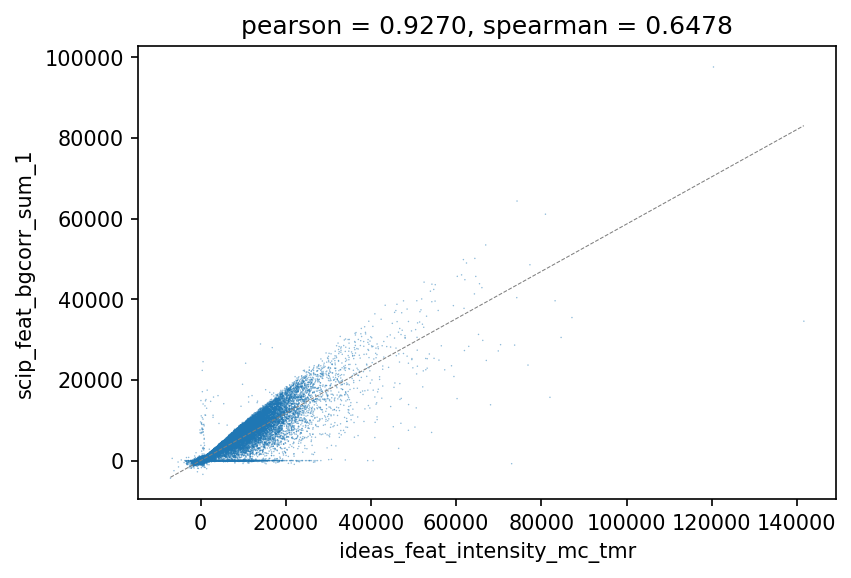

In [190]:
feature_comparison.compare_features(df, "ideas_feat_intensity_mc_tmr", "scip_feat_bgcorr_sum_1")

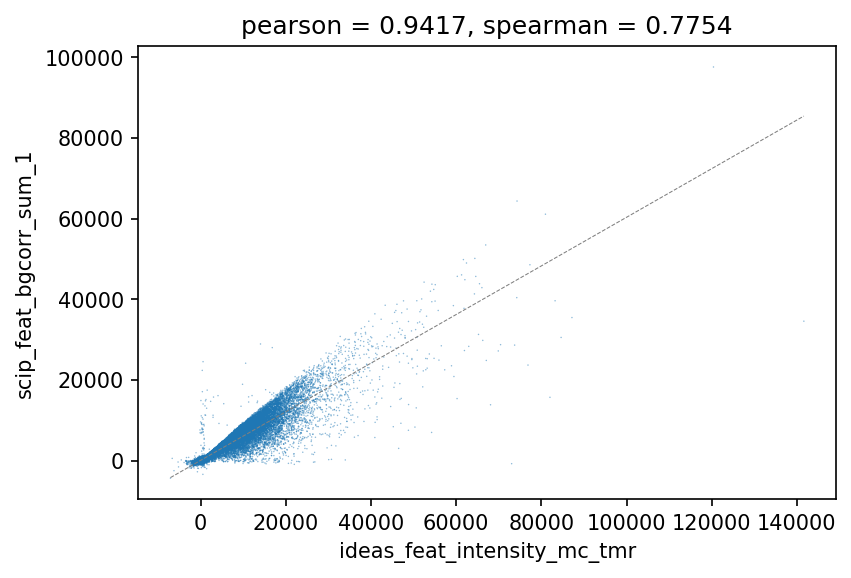

In [192]:
sel1 = df["scip_feat_bgcorr_sum_1"] == 0
sel2 = df["ideas_feat_intensity_mc_tmr"] != 0
feature_comparison.compare_features(df[~(sel1 & sel2)], "ideas_feat_intensity_mc_tmr", "scip_feat_bgcorr_sum_1")

In [194]:
df = df[~(sel1 & sel2)]
df.shape

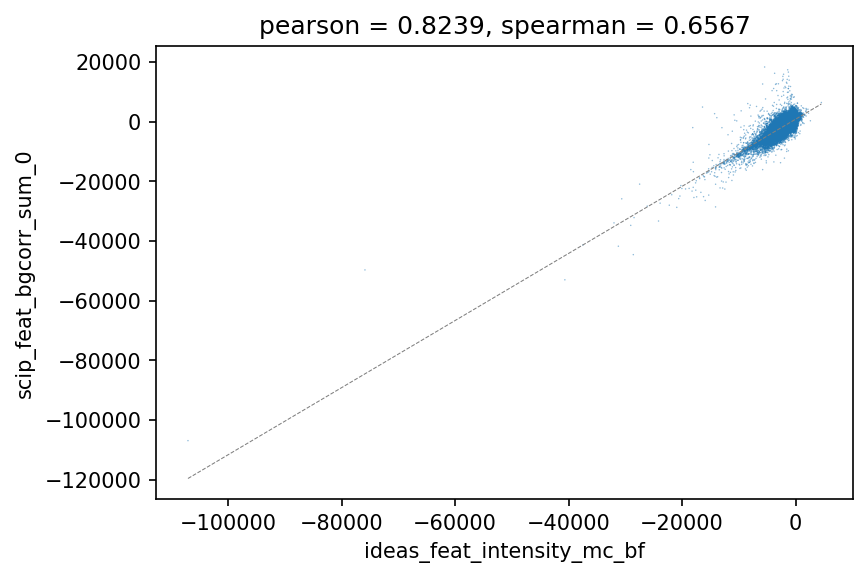

In [195]:
feature_comparison.compare_features(df, "ideas_feat_intensity_mc_bf", "scip_feat_bgcorr_sum_0")

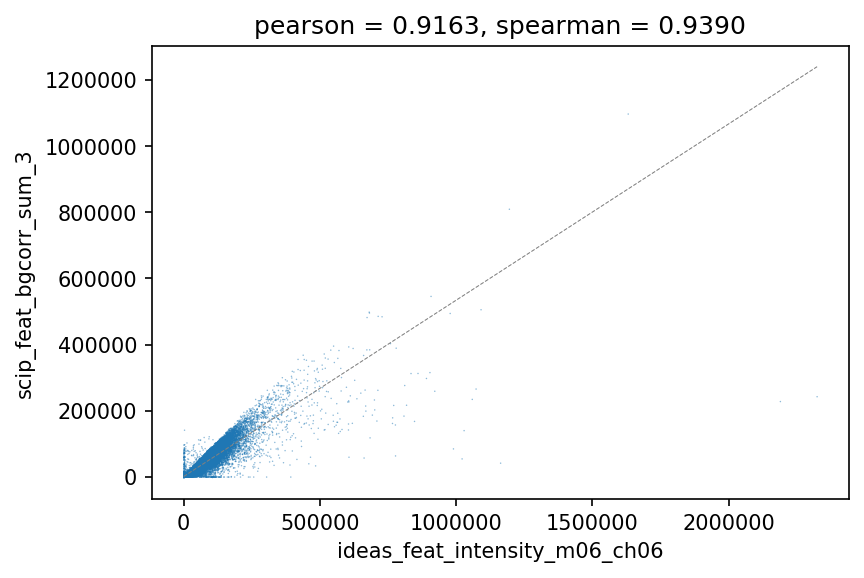

In [197]:
feature_comparison.compare_features(df, "ideas_feat_intensity_m06_ch06", "scip_feat_bgcorr_sum_3")

In [159]:
# df["meta_path"] = df["meta_path"].apply(lambda p: f"sftp://vsc42015@login.hpc.ugent.be:{p}")

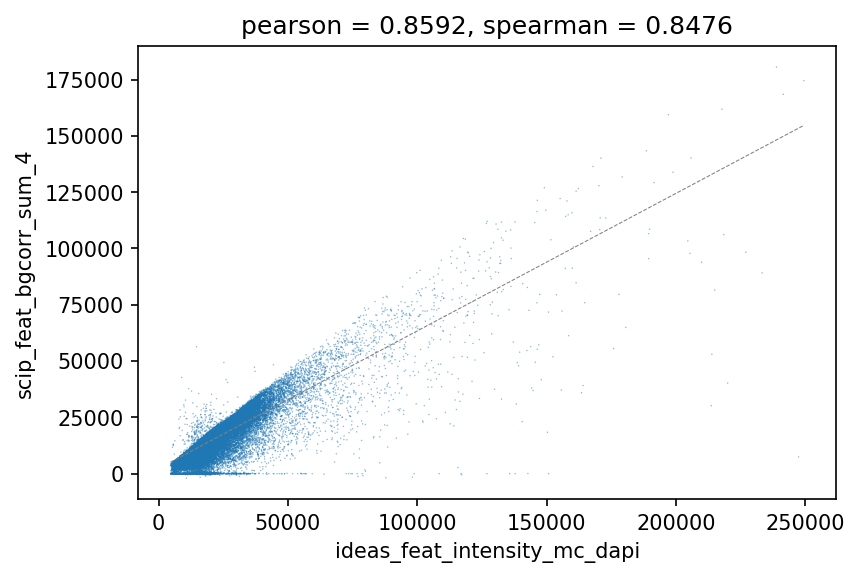

In [202]:
feature_comparison.compare_features(df, "ideas_feat_intensity_mc_dapi", "scip_feat_bgcorr_sum_4")

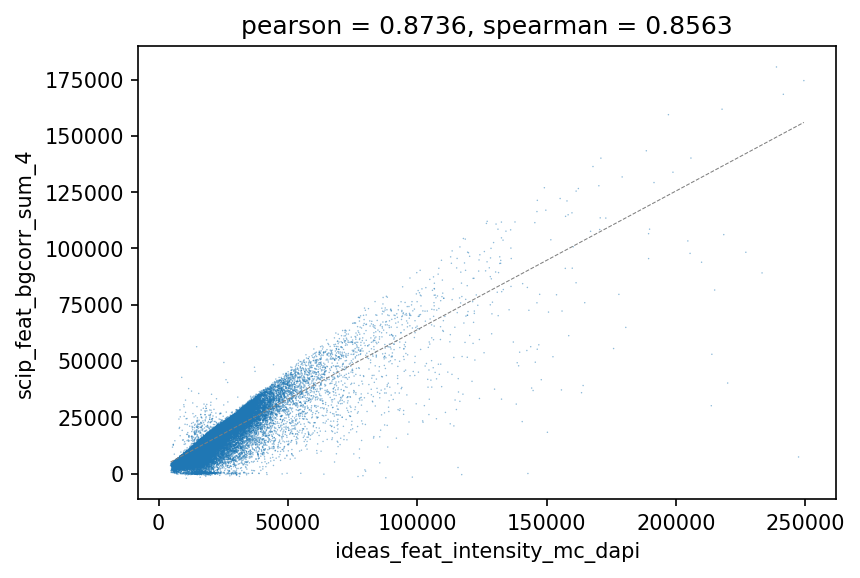

In [203]:
sel1 = df["ideas_feat_intensity_mc_dapi"] != 0
sel2 = df["scip_feat_bgcorr_sum_4"] == 0
feature_comparison.compare_features(df[~(sel1 & sel2)], "ideas_feat_intensity_mc_dapi", "scip_feat_bgcorr_sum_4")

In [204]:
df = df[~(sel1 & sel2)]
df.shape

(91862, 472)

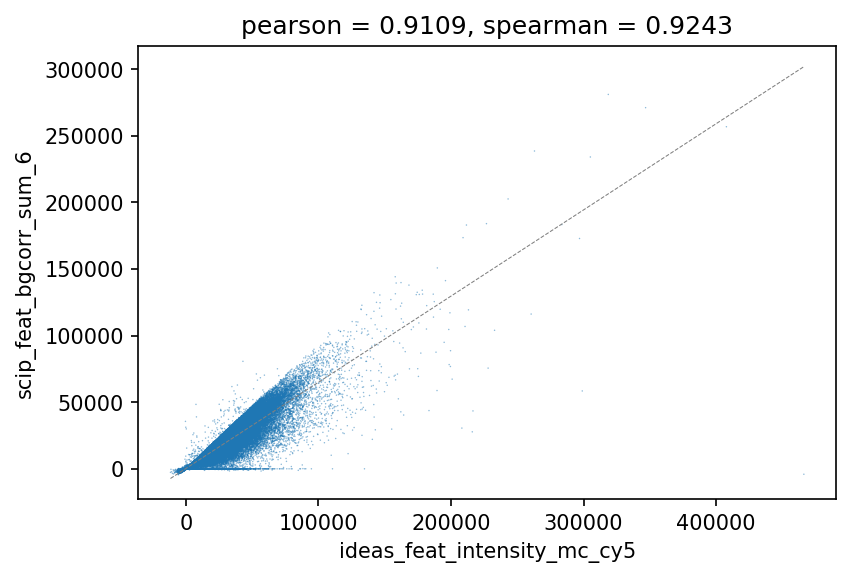

In [205]:
feature_comparison.compare_features(df, "ideas_feat_intensity_mc_cy5", "scip_feat_bgcorr_sum_6")

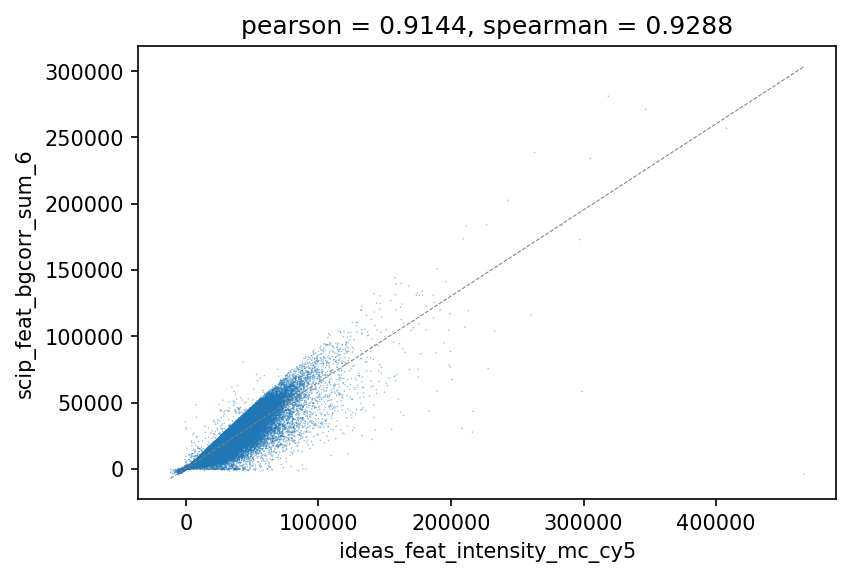

In [207]:
sel1 = df["ideas_feat_intensity_mc_cy5"] != 0
sel2 = df["scip_feat_bgcorr_sum_6"] == 0
feature_comparison.compare_features(df[~(sel1 & sel2)], "ideas_feat_intensity_mc_cy5", "scip_feat_bgcorr_sum_6")

In [208]:
df = df[~(sel1 & sel2)]
df.shape

(88194, 472)

# Predicting IDEAS manual gates from all fluorescence intensity features

This is a baseline sanity check. Training metrics should all be very high, since the manual gates have been set on the fluorescence intensity features using relatively simple rules.

In [209]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier

In [210]:
def predict_gates(X, y, model, seed=42):
    numpy.random.seed(42)
    
    scoring = ('balanced_accuracy', 'f1_macro', 'f1_micro', 'precision_macro', 'precision_micro', 'recall_macro', 'recall_micro')
    cv_results = cross_validate(
        estimator=model,
        X=X.values, y=y, cv=5,
        scoring=scoring,
        return_train_score=True,
        return_estimator=True,
        n_jobs=5
    )
    cv_df = pandas.DataFrame(
        data = {
            **{"phase": ["train"] * 5 + ["test"] * 5},
            **{k: numpy.concatenate([cv_results[f"train_{k}"], cv_results[f"test_{k}"]]) for k in scoring}
        }
    ).melt(id_vars=["phase"])
    seaborn.stripplot(data=cv_df, y="variable", x="value", hue="phase", jitter=0)

In [226]:
enc = LabelEncoder().fit(df["meta_label"])
y = enc.transform(df["meta_label"])

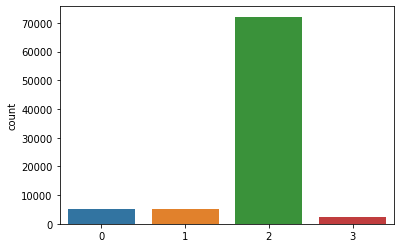

In [227]:
seaborn.countplot(x=y)

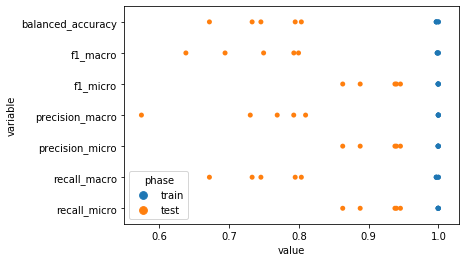

In [213]:
from sklearn import tree
model = tree.DecisionTreeClassifier()
predict_gates(
    df.filter(regex="scip_feat.*bgcorr.*sum.*"), y, 
    model
)

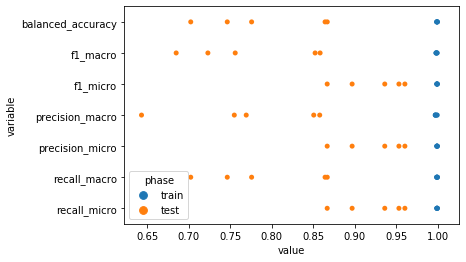

In [214]:
from sklearn import tree
model = tree.DecisionTreeClassifier()
predict_gates(
    df.filter(regex="ideas_feat_intensity_m.*"), y, 
    model
)

# Continue with events falling in cell states

Previously, unknown events falling between gates were also present.

In [215]:
df = df[df["meta_label"] != "unknown"]
df.shape

(85192, 472)

# QC plots of control and infected samples

In [216]:
import flowutils

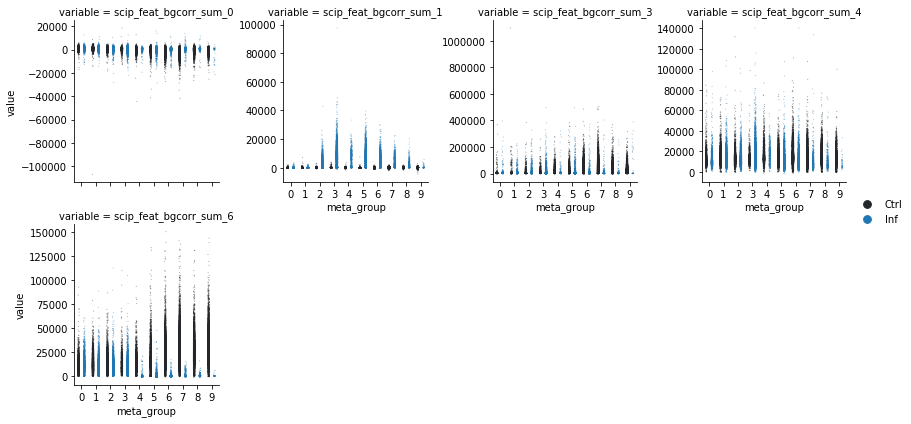

In [217]:
melted_df = pandas.melt(df.reset_index(), id_vars=["meta_type", "meta_group", "meta_replicate"], value_vars=df.filter(regex="scip_feat_bgcorr_sum_[0-9]").columns)
grid = seaborn.FacetGrid(data=melted_df, col="variable", col_wrap=4, sharey=False)
grid.map_dataframe(seaborn.stripplot, x="meta_group", y="value", hue="meta_type", dodge=True, size=1, alpha=0.5)
grid.add_legend()

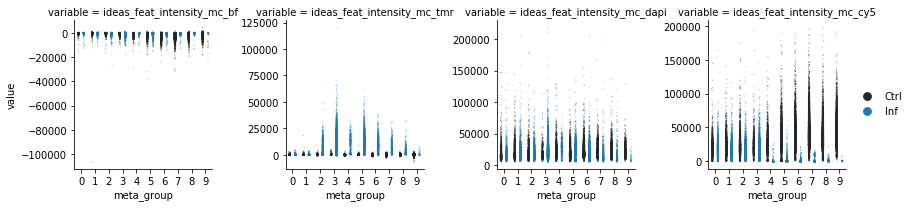

In [218]:
melted_df = pandas.melt(df.reset_index(), id_vars=["meta_type", "meta_group", "meta_replicate"], value_vars=df.filter(regex="ideas_feat_intensity_mc").columns)
grid = seaborn.FacetGrid(data=melted_df, col="variable", col_wrap=4, sharey=False)
grid.map_dataframe(seaborn.stripplot, x="meta_group", y="value", hue="meta_type", dodge=True, size=1, alpha=0.5)
grid.add_legend()

## Logicle transform

In [96]:
for k, gdf in df.groupby("meta_group"):
    gdf = gdf[["scip_feat_bgcorr_sum_1", "scip_feat_bgcorr_sum_4", "scip_feat_bgcorr_sum_6"]]
    transf = flowutils.transforms.logicle(gdf.values, w=1, channel_indices=None)
    df.loc[(slice(None), slice(None), k, slice(None)), ["scip_feat_bgcorr_sum_logicle_1", "scip_feat_bgcorr_sum_logicle_4", "scip_feat_bgcorr_sum_logicle_6"]] = transf


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


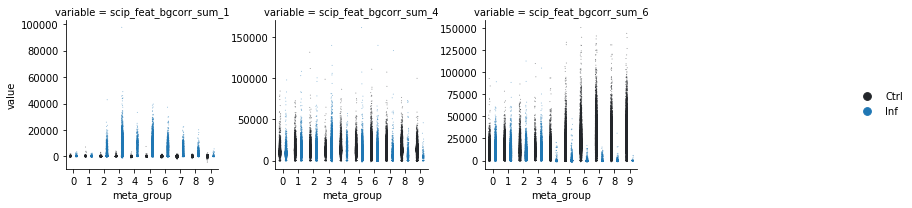

In [97]:
melted_df = pandas.melt(df.reset_index(), id_vars=["meta_type", "meta_group", "meta_replicate"], value_vars=df.filter(regex="scip_feat_bgcorr_sum_[1,4,6]").columns)
grid = seaborn.FacetGrid(data=melted_df, col="variable", col_wrap=4, sharey=False)
grid.map_dataframe(seaborn.stripplot, x="meta_group", y="value", hue="meta_type", dodge=True, size=1, alpha=0.5)
grid.add_legend()

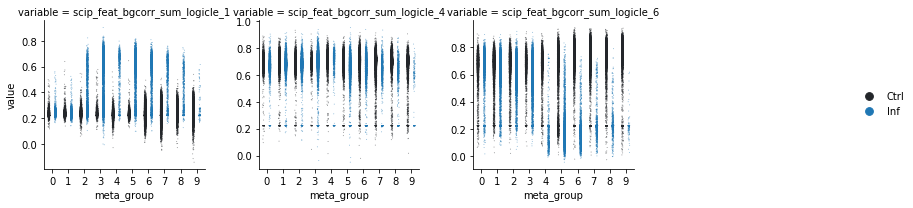

In [98]:
melted_df = pandas.melt(df.reset_index(), id_vars=["meta_type", "meta_group", "meta_replicate"], value_vars=df.filter(regex="scip_feat_bgcorr_sum_logicle_[0-9]").columns)
grid = seaborn.FacetGrid(data=melted_df, col="variable", col_wrap=4, sharey=False)
grid.map_dataframe(seaborn.stripplot, x="meta_group", y="value", hue="meta_type", dodge=True, size=1, alpha=0.5)
grid.add_legend()

# Clustering of events in infected samples

In [45]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize, scale, minmax_scale, LabelEncoder
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold

In [96]:
X = df.loc[:, :, :, "Inf"].filter(regex="scip_feat")
enc = LabelEncoder().fit(df["meta_label"])
enc.fit(df.loc[:, :, :, "Inf"]["meta_label"])
y = enc.transform(df.loc[:, :, :, "Inf"]["meta_label"])

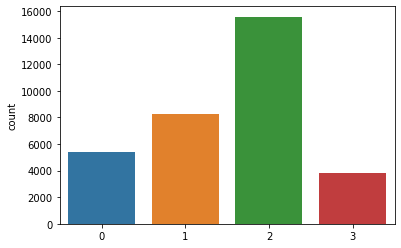

In [97]:
seaborn.countplot(x=y)

In [98]:
idx, _ = train_test_split(numpy.arange(len(X)), test_size=0.7, stratify=y)

In [99]:
X = X.iloc[idx].values
y = y[idx]
cols = df.filter(regex="scip_feat").columns.values

In [100]:
v = VarianceThreshold().fit(X)
X = v.transform(X)

In [101]:
cols = cols[v.get_support()]

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


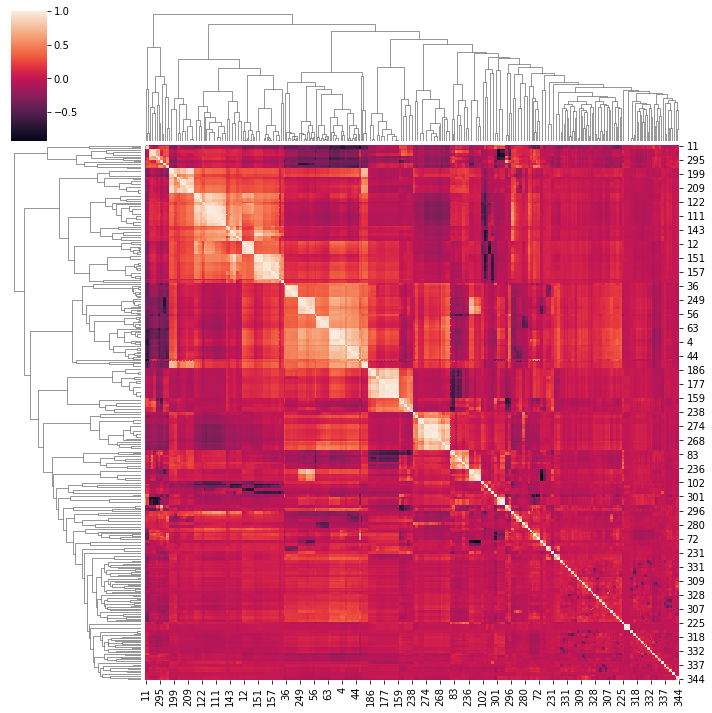

In [102]:
seaborn.clustermap(numpy.corrcoef(X, rowvar=False))

In [103]:
class Correlation():
    def __init__(self, thresh):
        self.thresh = thresh
    
    def fit(self, X):
        correlation = numpy.corrcoef(X, rowvar=False)
        var = X.var(axis=1)
        drop = set()
        for i in range(correlation.shape[0]):
            for j in range(i):
                if abs(correlation[i, j]) > self.thresh:
                    if var[i] >= var[j]:
                        c = i
                    else:
                        c = j
                    drop.add(c)
                    
        self.drop = list(drop)
        return self
        
    def transform(self, X, axis=1):
        return numpy.delete(X, self.drop, axis=axis)

In [104]:
corr = Correlation(0.9).fit(X)
X = corr.transform(X)
X.shape

(9915, 169)

In [105]:
cols = corr.transform(cols, axis=0)
len(cols)

169

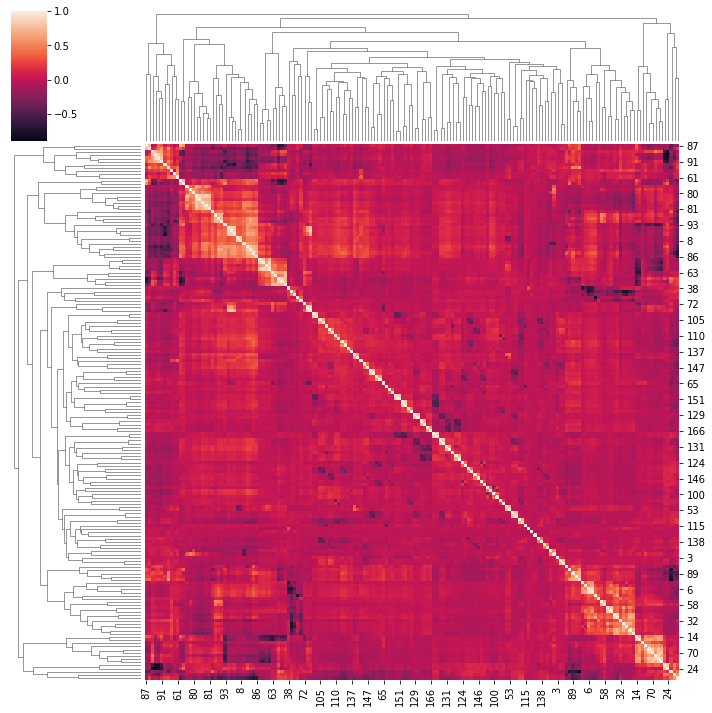

In [106]:
seaborn.clustermap(numpy.corrcoef(X, rowvar=False))

## Hierarchical clustering

In [107]:
%%time
agg = AgglomerativeClustering(
    n_clusters = 8,
    linkage = "ward"
).fit(scale(X))

CPU times: user 8.69 s, sys: 195 ms, total: 8.89 s
Wall time: 8.87 s


In [108]:
pca = PCA().fit_transform(scale(X))

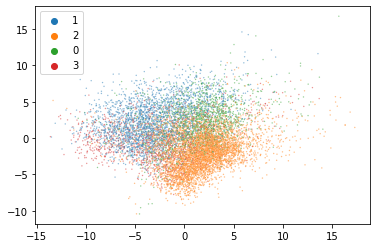

In [109]:
seaborn.scatterplot(x=pca[:, 0], y=pca[:, 1], edgecolors="none", hue=y.astype(str), s=2, alpha=0.5)

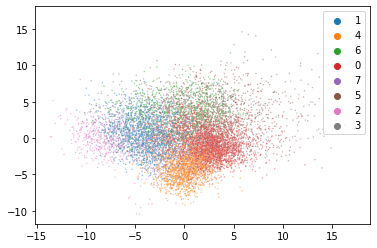

In [110]:
seaborn.scatterplot(x=pca[:, 0], y=pca[:, 1], edgecolors="none", hue=agg.labels_.astype(str), s=2, alpha=0.5)

In [111]:
df["meta_agg_clus"] = -1
df.iloc[idx, df.columns.get_loc("meta_agg_clus")] = agg.labels_

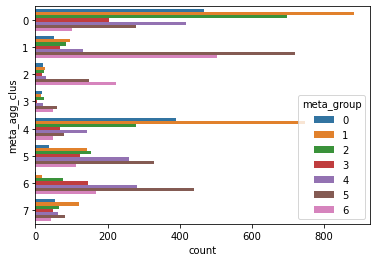

In [112]:
seaborn.countplot(data=df.iloc[idx].reset_index(), y="meta_agg_clus", hue="meta_group")

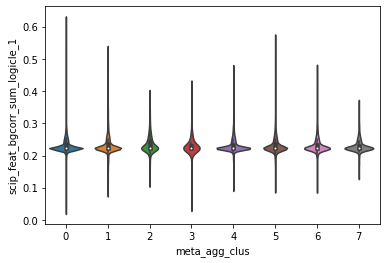

In [113]:
seaborn.violinplot(data=df.iloc[idx].reset_index(), y="scip_feat_bgcorr_sum_logicle_1", x="meta_agg_clus")

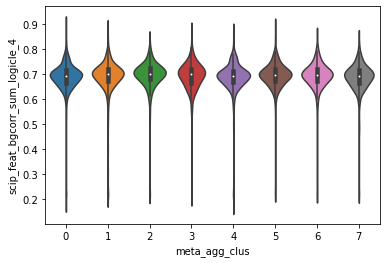

In [114]:
seaborn.violinplot(data=df.iloc[idx].reset_index(), y="scip_feat_bgcorr_sum_logicle_4", x="meta_agg_clus")

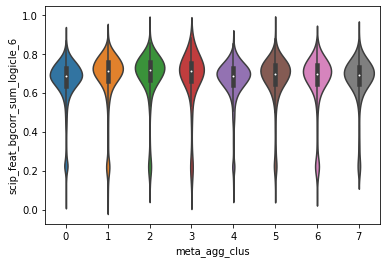

In [115]:
seaborn.violinplot(data=df.iloc[idx].reset_index(), y="scip_feat_bgcorr_sum_logicle_6", x="meta_agg_clus")

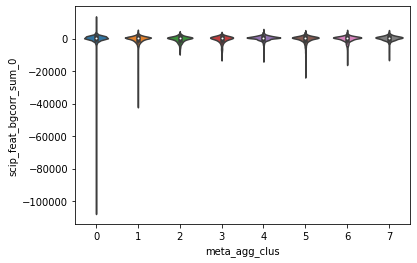

In [116]:
seaborn.violinplot(data=df.iloc[idx].reset_index(), y="scip_feat_bgcorr_sum_0", x="meta_agg_clus")

In [118]:
X = df.filter(regex="scip_feat").iloc[idx]
y = df["meta_agg_clus"].iloc[idx]
model = XGBClassifier(use_label_encoder=False, tree_method="gpu_hist").fit(X.values, y.values.astype(int))

[16:26:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [119]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


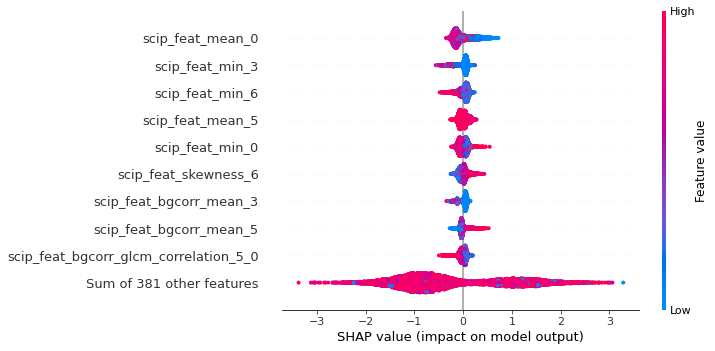

In [120]:
shap.plots.beeswarm(shap_values[..., 0])

# Prediction of cell states based on all channels except MCP and PSBA channel

We don't use features derived from channel indices 1, 2 and 6 (which correspond to TMR and PSBA)

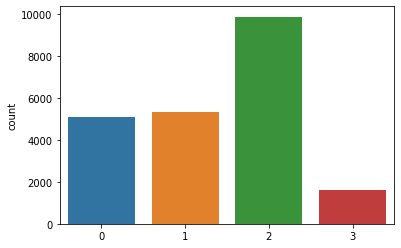

In [231]:
enc = LabelEncoder().fit(df.loc[:, :, :, "Inf"]["meta_label"])
y = enc.transform(df.loc[:, :, :, "Inf"]["meta_label"])
seaborn.countplot(x=y)

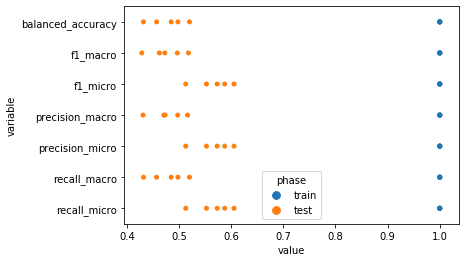

In [220]:
to_keep = df.filter(regex=".*scip.*[0,3,4]$").columns
X = df.loc[:, :, :, "Inf"][to_keep]
predict_gates(X, y, tree.DecisionTreeClassifier())

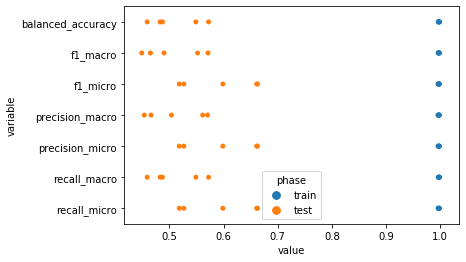

In [255]:
to_keep = df.filter(regex=".*ideas.*(m01|bf|m06|ch06|m07|dapi).*").columns
to_keep = numpy.array([f for f in to_keep if not (("tmr" in f) or ("cy5" in f))]) # filter out similarity features with fluorescence channels
X = df.loc[:, :, :, "Inf"][to_keep]
predict_gates(X, y, tree.DecisionTreeClassifier())

## SHAP analysis to identify features explaining cell states

In [190]:
to_keep = df.filter(regex=".*scip.*bgcorr.*[0,3,4]$").columns
X = df.loc[:, :, :, "Inf"][to_keep]
model = XGBClassifier(use_label_encoder=False, tree_method="gpu_hist").fit(X.values, y)

[17:02:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [191]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


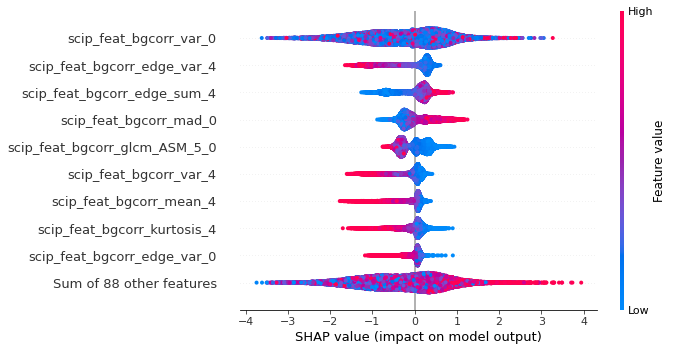

In [219]:
label = enc.transform(["mcp-_psba+"])[0]
shap.plots.beeswarm(shap_values[:, :, label])

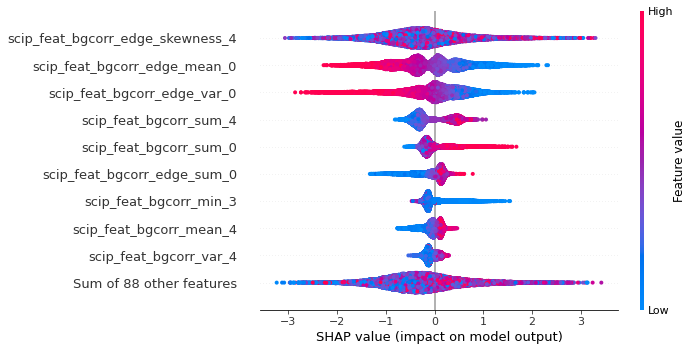

In [220]:
label = enc.transform(["mcp+_psba+"])[0]
shap.plots.beeswarm(shap_values[:, :, label])

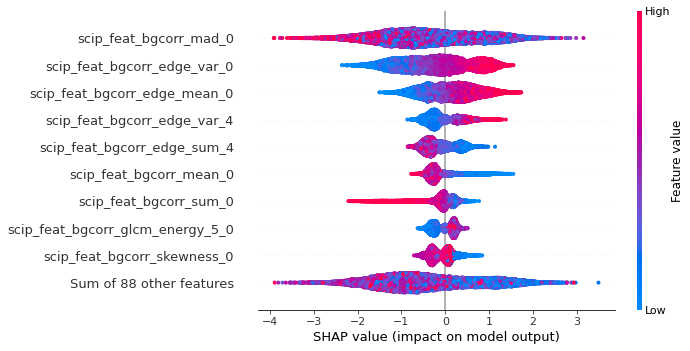

In [221]:
label = enc.transform(["mcp+_psba-"])[0]
shap.plots.beeswarm(shap_values[:, :, label])

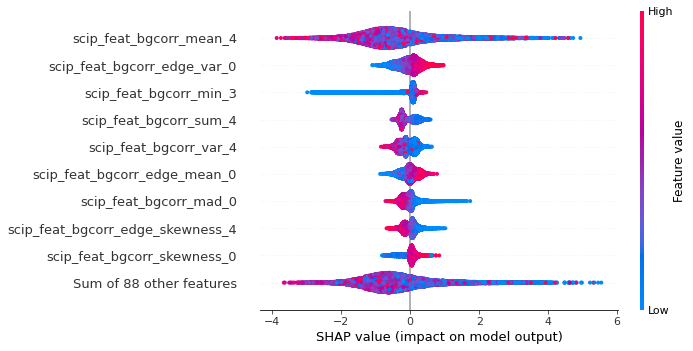

In [222]:
label = enc.transform(["mcp-_psba-"])[0]
shap.plots.beeswarm(shap_values[:, :, label])

### BF mean edge pixel value

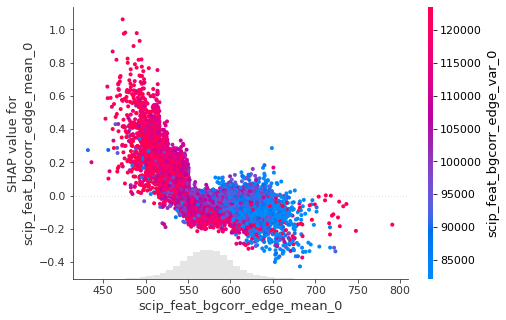

In [211]:
label = enc.transform(["mcp-_psba+"])[0]
shap.plots.scatter(shap_values[:, "scip_feat_bgcorr_edge_mean_0", label], color=shap_values[:, :, label])

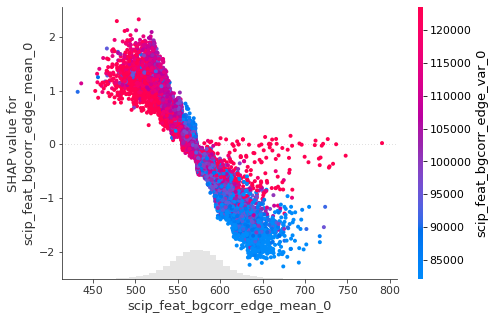

In [212]:
label = enc.transform(["mcp+_psba+"])[0]
shap.plots.scatter(shap_values[:, "scip_feat_bgcorr_edge_mean_0", label], color=shap_values[:, :, label])

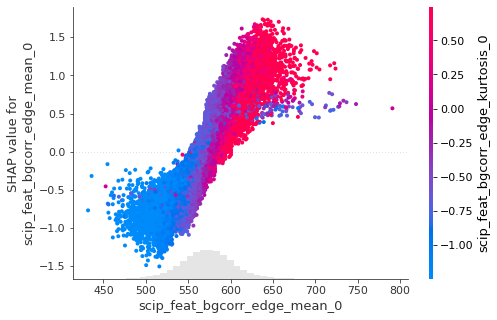

In [213]:
label = enc.transform(["mcp+_psba-"])[0]
shap.plots.scatter(shap_values[:, "scip_feat_bgcorr_edge_mean_0", label], color=shap_values[:, :, label])

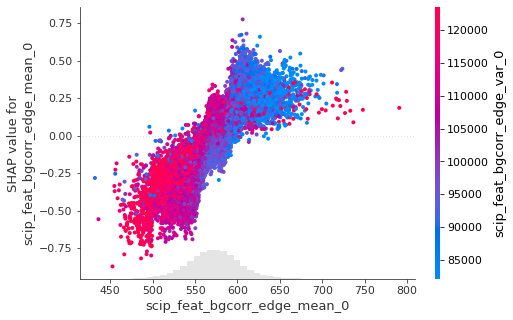

In [214]:
label = enc.transform(["mcp-_psba-"])[0]
shap.plots.scatter(shap_values[:, "scip_feat_bgcorr_edge_mean_0", label], color=shap_values[:, :, label])

In [225]:
interaction = explainer.shap_interaction_values(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [229]:
len(interaction)

4

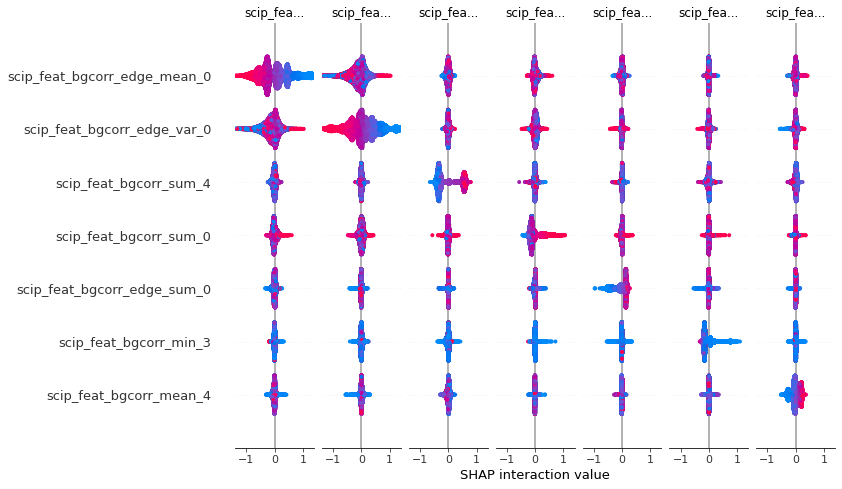

In [230]:
shap.summary_plot(interaction[0], X)

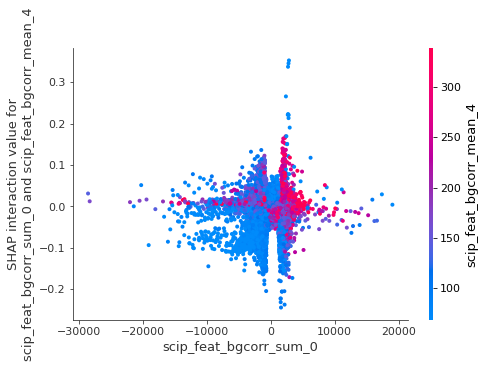

In [233]:
shap.dependence_plot(
    ("scip_feat_bgcorr_sum_0", "scip_feat_bgcorr_mean_4"),
    interaction[0], X
)

### BF intensity

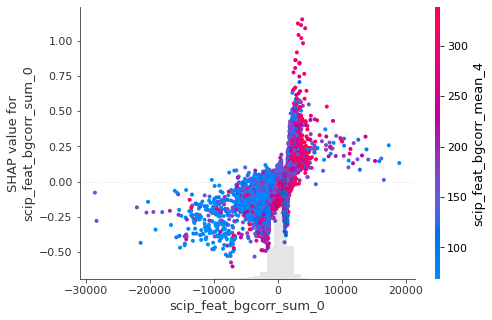

In [208]:
label = enc.transform(["mcp-_psba+"])[0]
shap.plots.scatter(shap_values[:, "scip_feat_bgcorr_sum_0", label], color=shap_values[:, :, label])

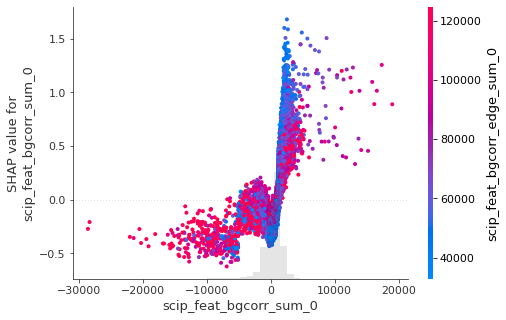

In [193]:
label = enc.transform(["mcp+_psba+"])[0]
shap.plots.scatter(shap_values[:, "scip_feat_bgcorr_sum_0", label], color=shap_values[:, :, label])

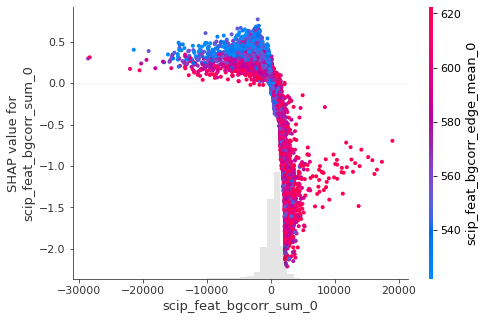

In [194]:
label = enc.transform(["mcp+_psba-"])[0]
shap.plots.scatter(shap_values[:, "scip_feat_bgcorr_sum_0", label], color=shap_values[:, :, label])

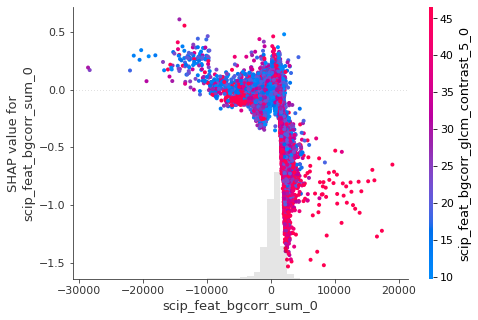

In [195]:
label = enc.transform(["mcp-_psba-"])[0]
shap.plots.scatter(shap_values[:, "scip_feat_bgcorr_sum_0", label], color=shap_values[:, :, label])

### DAPI intensity

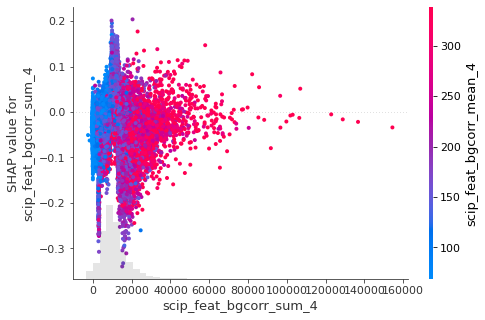

In [196]:
label = enc.transform(["mcp-_psba+"])[0]
shap.plots.scatter(shap_values[:, "scip_feat_bgcorr_sum_4", label], color=shap_values[:, :, label])

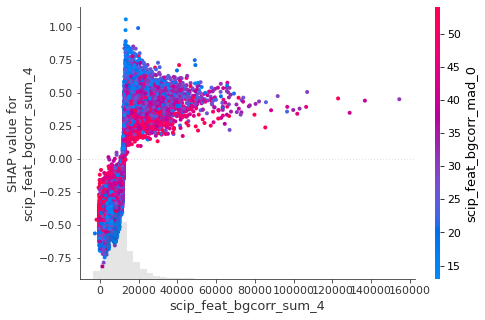

In [197]:
label = enc.transform(["mcp+_psba+"])[0]
shap.plots.scatter(shap_values[:, "scip_feat_bgcorr_sum_4", label], color=shap_values[:, :, label])

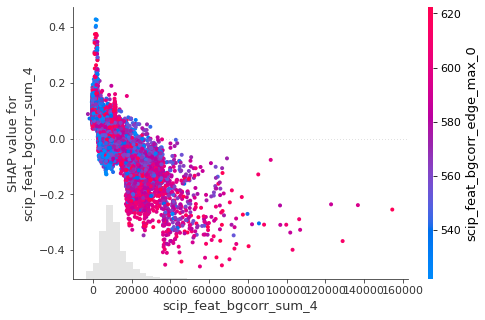

In [200]:
label = enc.transform(["mcp+_psba-"])[0]
shap.plots.scatter(shap_values[:, "scip_feat_bgcorr_sum_4", label], color=shap_values[:, :, label])

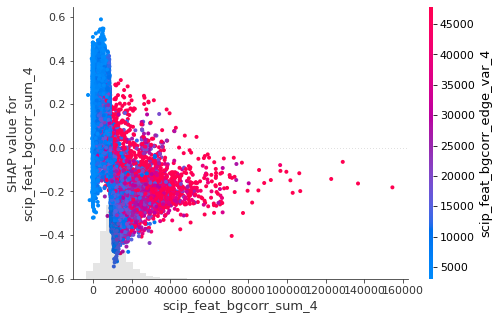

In [201]:
label = enc.transform(["mcp-_psba-"])[0]
shap.plots.scatter(shap_values[:, "scip_feat_bgcorr_sum_4", label], color=shap_values[:, :, label])